In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
import torch
import matplotlib.pyplot as plt
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from ImportanceSampling.AnnealedImportanceSampler import AnnealedImportanceSampler
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from FittedModels.Models.FlowModel import FlowModel
import time

In [5]:
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function

## Setup Problem

In [6]:
torch.manual_seed(0)
n_samples = int(1e4)
dim = 3 # 2 for plotting, 5 to make more difficult but then plots make less sense
#************ EASY ******************
#target = Guassian_FullCov(dim=dim)
#learnt_sampler = DiagonalGaussian(dim=dim)

#************* HARD ************************
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=3.0)

#****************************************
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # should print 2 similar-ish numbers

tensor(29.2686)
tensor(29.2762)


## Annealed Importance Sampling 

In [18]:
AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="geometric", n_distributions=20, 
                                n_steps_transition_operator=20)

In [19]:
start = time.time()
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")
print((time.time() - start)/60)

true expectation is 29.26856803894043, estimated expectation is 28.882614135742188
ESS is 0.18596555292606354, var is 4.377778139996735e-08
0.45594094196955365


### Plotting

Text(0.5, 1.0, 'true samples')

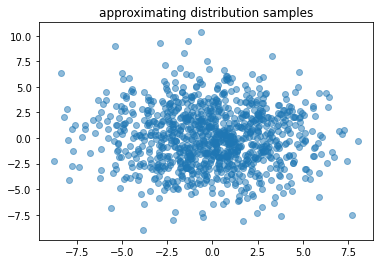

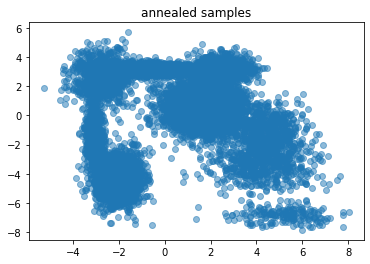

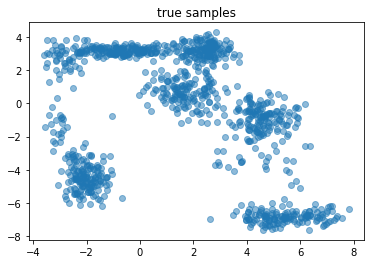

In [21]:
plt.figure()
learnt_dist_samples = learnt_sampler.sample((1000,)).detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1], alpha=0.5)
plt.title("approximating distribution samples")
plt.figure()
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1], alpha=0.5)
plt.title("annealed samples")
plt.figure()
true_samples = target.sample((1000,)).detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1], alpha=0.5)
plt.title("true samples")

### with linear spacing

In [22]:
AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="linear")
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(true_expectation, expectation)
print(info_dict["effective_sample_size"]/n_samples, torch.var(info_dict['normalised_sampling_weights']))

tensor(29.2686) tensor(28.0043)
tensor(0.5293) tensor(8.8936e-09)


## Annealed Importance Sampling - with HMC

In [23]:
AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="geometric",
                               transition_operator="HMC", n_steps_transition_operator=2, 
                               HMC_inner_steps=3, n_distributions=20)

In [24]:
start = time.time()
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")
print((time.time() - start)/60)

true expectation is 29.26856803894043, estimated expectation is 33.313941955566406
ESS is 0.05368956923484802, var is 1.762735450938635e-07
0.3696903308232625


### Plotting

Text(0.5, 1.0, 'true samples')

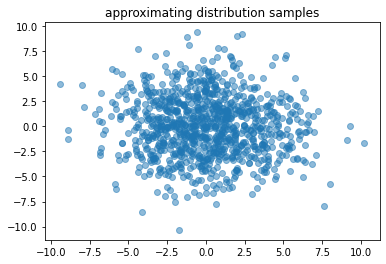

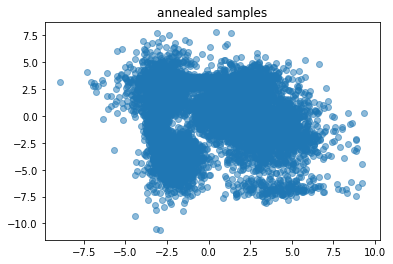

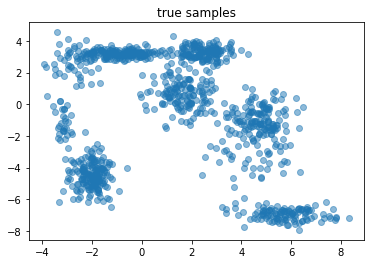

In [25]:
plt.figure()
learnt_dist_samples = learnt_sampler.sample((1000,)).detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1], alpha=0.5)
plt.title("approximating distribution samples")
plt.figure()
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1], alpha=0.5)
plt.title("annealed samples")
plt.figure()
true_samples = target.sample((1000,)).detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1], alpha=0.5)
plt.title("true samples")

## More steps HMC

In [26]:
AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="geometric",
                               transition_operator="HMC", n_steps_transition_operator=20, 
                               HMC_inner_steps=3, n_distributions=20)

In [27]:
start = time.time()
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")
print((time.time() - start)/60)

true expectation is 29.26856803894043, estimated expectation is 29.04821014404297
ESS is 0.18504787981510162, var is 4.404447295769387e-08
3.5836078484853107


### Plotting

Text(0.5, 1.0, 'true samples')

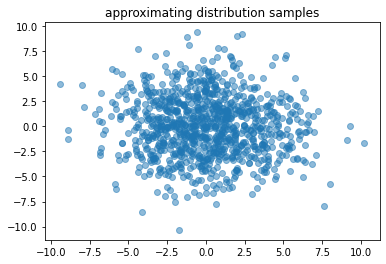

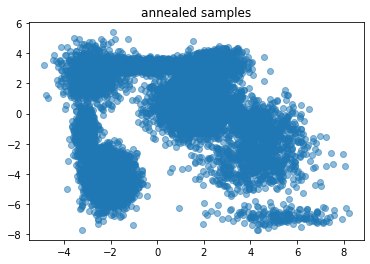

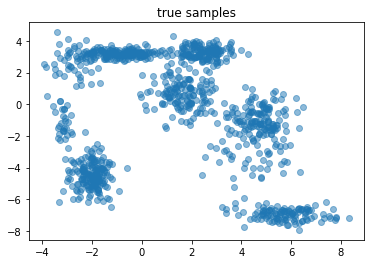

In [28]:
plt.figure()
learnt_dist_samples = learnt_sampler.sample((1000,)).detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1], alpha=0.5)
plt.title("approximating distribution samples")
plt.figure()
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1], alpha=0.5)
plt.title("annealed samples")
plt.figure()
true_samples = target.sample((1000,)).detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1], alpha=0.5)
plt.title("true samples")

## Standard Importance Sampling

In [ ]:
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)

In [ ]:
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = vanilla_IS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation_vanilla}")
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

## Annealed Importance Sampling with more intermediate distributions
Improves ESS

In [ ]:
AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="geometric",
                                n_distributions=400, n_updates_Metropolis=20,)

In [ ]:
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")

### with linear spacing

In [ ]:

AIS = AnnealedImportanceSampler(sampling_distribution=learnt_sampler, target_distribution=target,
                                                        distribution_spacing="linear",
                                n_distributions=400, n_updates_Metropolis=20,)
with torch.no_grad():
    expectation, info_dict = AIS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(f"ESS is {info_dict['effective_sample_size']/n_samples}, var is {torch.var(info_dict['normalised_sampling_weights'])}")

In [ ]:
plt.figure()
learnt_dist_samples = learnt_sampler.sample((1000,)).detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1])
plt.title("approximating distribution samples")
plt.figure()
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1])
plt.title("annealed samples")
plt.figure()
true_samples = target.sample((1000,)).detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1])
plt.title("true samples")